In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
%matplotlib inline

In [49]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submit = pd.read_csv('sample_submission.csv')

In [50]:
df_all = pd.concat([train, test], axis=0)
print "%s, %s, %s" % (train.shape, test.shape, df_all.shape)


(114321, 133), (114393, 132), (228714, 133)


In [51]:
na_columns = map(lambda x: x+'_na', df_all.columns)
df_all_na = df_all.isnull().astype(int)
df_all_na.columns = na_columns

In [52]:
df_all = pd.concat([df_all, df_all_na], axis=1)
df_all.shape

(228714, 266)

In [53]:
cat_features= train.select_dtypes(include=['object']).columns
cont_features = train.select_dtypes(exclude=['object']).columns[2:] #removing id & target
print "cat_features: %s" % cat_features
print "cont_features: %s" % cont_features

cat_features: Index([u'v3', u'v22', u'v24', u'v30', u'v31', u'v47', u'v52', u'v56', u'v66',
       u'v71', u'v74', u'v75', u'v79', u'v91', u'v107', u'v110', u'v112',
       u'v113', u'v125'],
      dtype='object')
cont_features: Index([u'v1', u'v2', u'v4', u'v5', u'v6', u'v7', u'v8', u'v9', u'v10', u'v11',
       ...
       u'v121', u'v122', u'v123', u'v124', u'v126', u'v127', u'v128', u'v129',
       u'v130', u'v131'],
      dtype='object', length=112)


In [54]:
''' handling missing values
imputer NaN with most_frequent value for categorial features
'''

most_frequent_cat_value = {}
for feature in cat_features:
    most_frequent_cat_value[feature] = df_all[feature].value_counts().index[0]
print most_frequent_cat_value
for feature in cat_features:
    df_all[feature] = df_all[feature].fillna(value=most_frequent_cat_value[feature])

{'v30': 'C', 'v22': 'AGDF', 'v91': 'A', 'v79': 'C', 'v31': 'A', 'v74': 'B', 'v66': 'A', 'v24': 'E', 'v110': 'A', 'v71': 'F', 'v112': 'F', 'v113': 'G', 'v56': 'BW', 'v107': 'E', 'v3': 'C', 'v52': 'J', 'v47': 'C', 'v75': 'D', 'v125': 'BM'}


In [55]:
''' handling missing values
imputer NaN with mean value for continuous features
'''
from sklearn.preprocessing import Imputer
imp = Imputer()
df_all[cont_features] = imp.fit_transform(df_all[cont_features])



In [56]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(np.unique(df_all[cat_features]).ravel())
df_all[cat_features] = le.transform(df_all[cat_features])
''' standard scaling'''
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_all[cont_features.union(cat_features)] = scaler.fit_transform(df_all[cont_features.union(cat_features)])


In [57]:
import xgboost as xgb
#Recreate train / test
train = df_all[df_all.target.notnull()].drop(['ID','target'], axis=1) 
test = df_all[df_all.target.isnull()].drop(['ID','target'], axis=1) 
index_test = df_all[df_all.target.isnull()]['ID'].values 
target = df_all[df_all.target.notnull()].target.values

In [13]:
##################
# Train & Predict
##################
dtrain = xgb.DMatrix(train, label=target)
dtest = xgb.DMatrix(test)
param = {'max_depth': 10, 'eta': 0.1, 'silent': 1, 'objective': 'binary:logistic',
         'lambda': 1, 'subsample': 0.9, 'eval_metric': 'auc'}
num_rounds = 150
bst = xgb.train(param, dtrain, num_rounds)
y_predict = bst.predict(dtest)

''' writing prediction to file'''
df_submit = pd.DataFrame(columns = submit.columns)
df_submit.ID = index_test
df_submit.PredictedProb = y_predict
df_submit.to_csv('submission.csv', index=False)

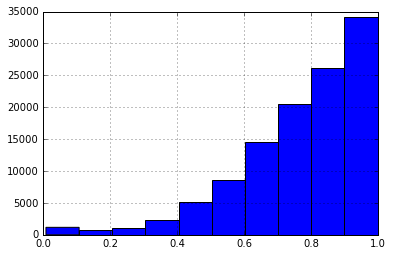

In [16]:
df_submit.PredictedProb.hist()

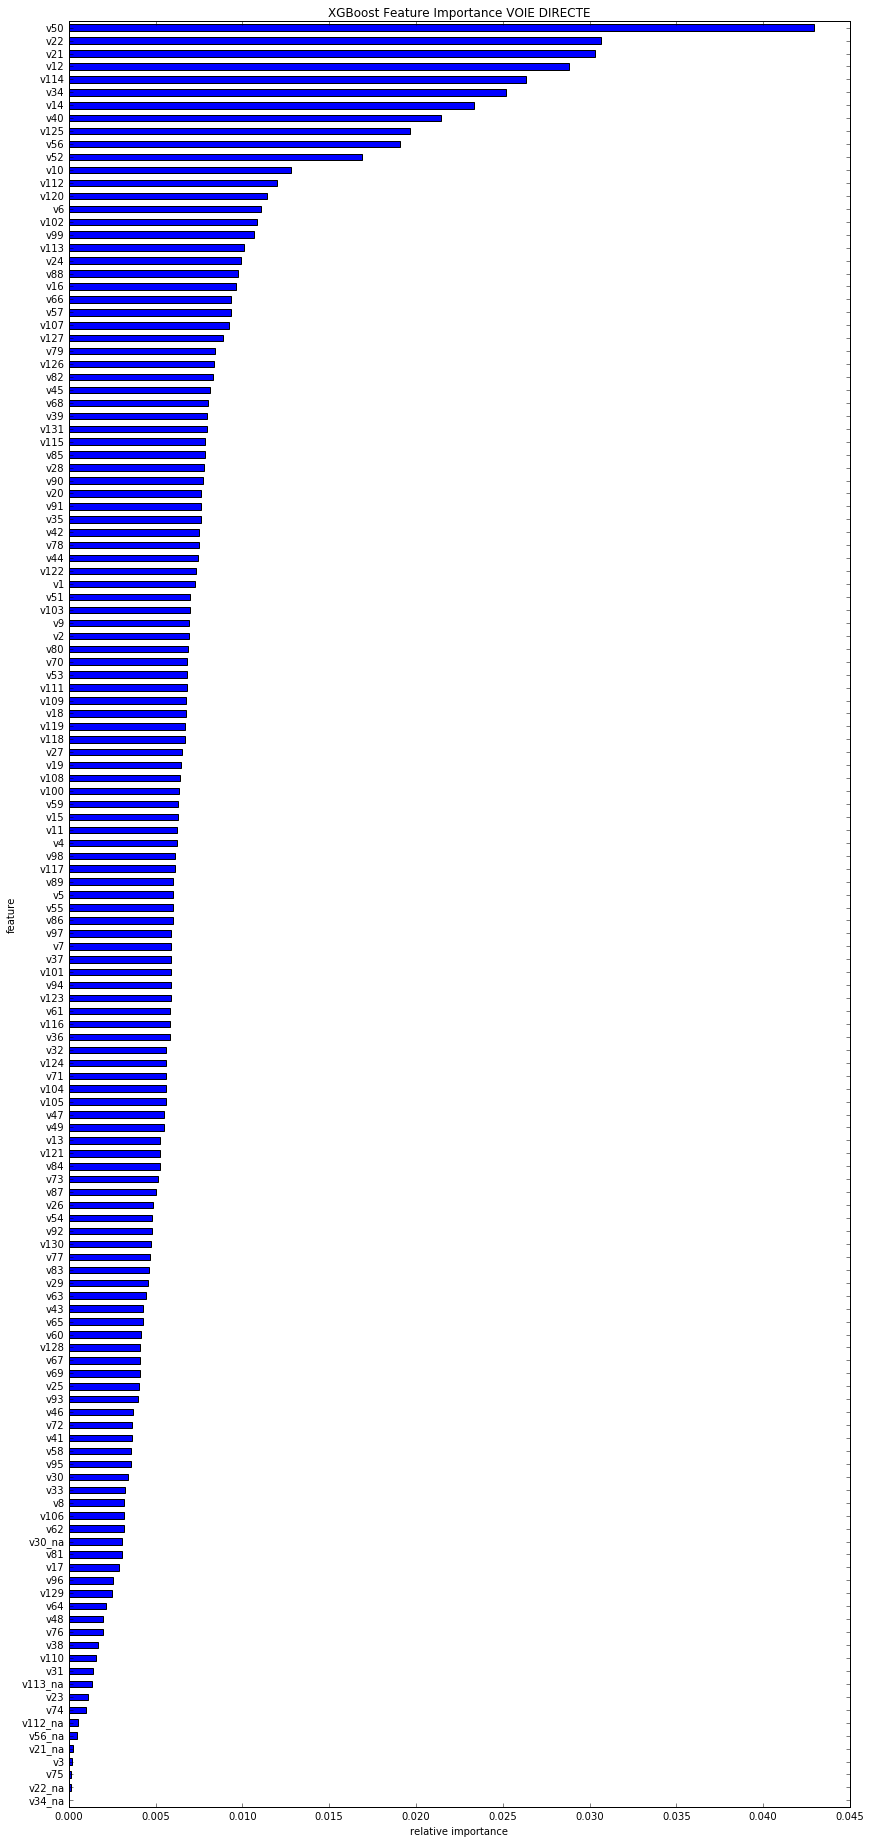

In [24]:
import operator
importance = bst.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))

df_imp = pd.DataFrame(importance, columns=['feature', 'fscore'])
df_imp['fscore'] = df_imp['fscore'] / df_imp['fscore'].sum()

plt.close('all')
plt.figure(figsize=(14, 32))
ax = plt.subplot(111)
df_imp.plot(kind='barh', x='feature', y='fscore', legend=False, ax = ax)
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

In [58]:
''' Wrapper for SKLearn'''
class MyXGB(BaseEstimator, ClassifierMixin):
    """Scikit-Learn wrapper for XGBoost."""

    def __init__(self, param, num_rounds):
        self.param = param
        self.num_rounds = num_rounds

    def fit(self, X, y):
        dx = xgb.DMatrix(X, label=y)
        estimator_ = xgb.train(self.param, dx, self.num_rounds)
        self.estimator_ = estimator_
        self.feature_importances_ = np.array(estimator_.get_fscore().values())
        return self

    def predict_proba(self, X):
        dx = xgb.DMatrix(X)
        return self.estimator_.predict(dx)

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

In [63]:
from sklearn.cross_validation import cross_val_score
param = {'max_depth': 10, 'eta': 0.1, 'silent': 1, 'objective': 'binary:logistic',
         'lambda': 1, 'subsample': 0.9, 'eval_metric': 'auc'}
num_rounds = 150
clf = xgb.XGBClassifier(max_depth=10, learning_rate=0.1, n_estimators=150,
                 silent=True, objective='binary:logistic',
                 nthread=-1, gamma=0, min_child_weight=1, max_delta_step=0,
                 subsample= 0.9, colsample_bytree=1, colsample_bylevel=1,
                 reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                 base_score=0.5, seed=42, missing=None)



In [65]:
cross_val_score(clf, train, target, scoring = 'roc_auc' )#

array([ 0.7493623 ,  0.75679373,  0.75397304])

In [70]:
from sklearn.feature_selection import RFECV
from sklearn.cross_validation import StratifiedKFold

def _create_selector(train, target):
    
    param = {'max_depth': 10, 'eta': 0.1, 'silent': 1, 'objective': 'multi:softprob',
             'lambda': 1, 'subsample': 0.9, 'eval_metric': 'auc', 'num_class': 2}
    num_rounds = 150
    rfecv = RFECV(estimator=MyXGB(param, num_rounds), cv=StratifiedKFold(target, 2), scoring='roc_auc')
    rfecv.fit(train, target)

    print("Optimal number of features : %d" % rfecv.n_features_)

    np.savetxt('feature_selector_support.txt', rfecv.support_, fmt='%s')

    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()

In [ ]:
_create_selector(train, target)